In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from colour_demosaicing import masks_CFA_Bayer
from timeit import default_timer as timer

from heuristic1 import heuristic_1
from heuristic2 import heuristic_2
from heuristic3 import heuristic_3
from heuristic4 import heuristic_4

from utils import plot_channel, the_to_q, q_to_the

`lpar1` = 100, `lpar2` = [1000/3, 1000/3, 1000/3], `lpar3` = [1000/3, 1000/3, 1000/3], `lpar4` = [1000/3, 1000/3, 1000/3]

In [3]:
shape = (300, 200)
start = (50, 50)
image = imread('image/oski.png', 'png')   
image = image[start[0]:start[0]+shape[0], start[1]:start[1]+shape[1], :]

bayer_filter = np.stack(masks_CFA_Bayer(shape), axis=-1).astype(float)
mosaic_image = image * bayer_filter

lpar1 = 100
lpar2 = 1000
lpar3 = 1000
lpar4 = 1000

block_shape = [6, 4]
region_shape = [6, 4]
min_n_pix = 4

# start_1 = timer()
# _, Psi_1, mu_1, the_1 = heuristic_1(mosaic_image, [12, 8, 1], lpar=lpar1, tol=1e-2, verbose=False)
# end_1 = timer()

start_2 = timer()
Psi_2, mu_2, the_2 = heuristic_2(p_0=mosaic_image, block_shape=block_shape, min_n_pix=min_n_pix, lpars=[lpar2/3, lpar2/3, lpar2/3], verbose=False)
end_2 = timer()

start_3 = timer()
Psi_3, mu_3, the_3 = heuristic_3(p_0=mosaic_image, region_shape=region_shape, lpars=[lpar3/3, lpar3/3, lpar3/3], verbose=False)
end_3 = timer()

start_4 = timer()
Psi_4, mu_4, the_4 = heuristic_4(p_0=mosaic_image, min_n_pix=min_n_pix, lpars=[lpar4/3, lpar4/3, lpar4/3], verbose=False)
end_4 = timer()

# print(f'Heuristic 1: Sum of mu is {sum(mu_1)}. Store {len(the_1)} vertices. Run time is {end_1 - start_1}')
print(f'Heuristic 2: Sum of mu is {sum(mu_2)}. Store {len(the_2)} vertices. Block shape is {block_shape}. Minimal region area is {min_n_pix}. Run time is {end_2 - start_2}')
print(f'Heuristic 3: Sum of mu is {sum(mu_3)}. Store {len(the_3)} vertices. Region shape is {region_shape}. Run time is {end_3 - start_3}')
print(f'Heuristic 4: Sum of mu is {sum(mu_4)}. Store {len(the_4)} vertices. Minimal region area is {min_n_pix}. Run time is {end_4 - start_4}')

fig, axes = plt.subplots(1, 6, figsize=(30, 8))
axes[0].imshow(image)
axes[1].imshow(mosaic_image)
# axes[2].imshow(Psi_1)
axes[3].imshow(Psi_2)
axes[4].imshow(Psi_3)
axes[5].imshow(Psi_4)

axes[0].set_title('Original image')
axes[1].set_title('Mosaic image')
axes[2].set_title('Heuristic 1')
axes[3].set_title('Heuristic 2')
axes[4].set_title('Heuristic 3')
axes[5].set_title('Heuristic 4')
fig.savefig('comparison.png')



Heuristic 2: N_t + mu_t 333.7764775492251 is larger than lpar 333.3333333333333 in channel 0
Heuristic 2: N_t + mu_t 333.54118471965194 is larger than lpar 333.3333333333333 in channel 1


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


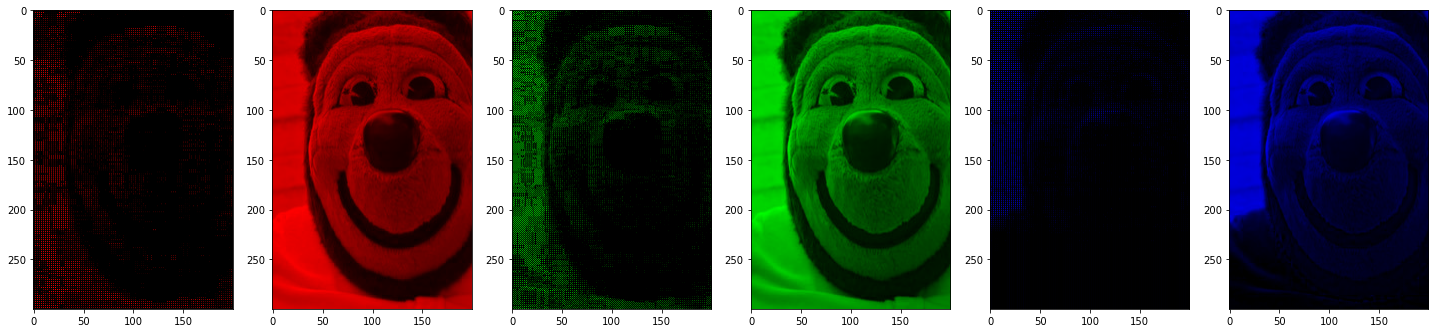

In [35]:
plot_channel(Psi_1, image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


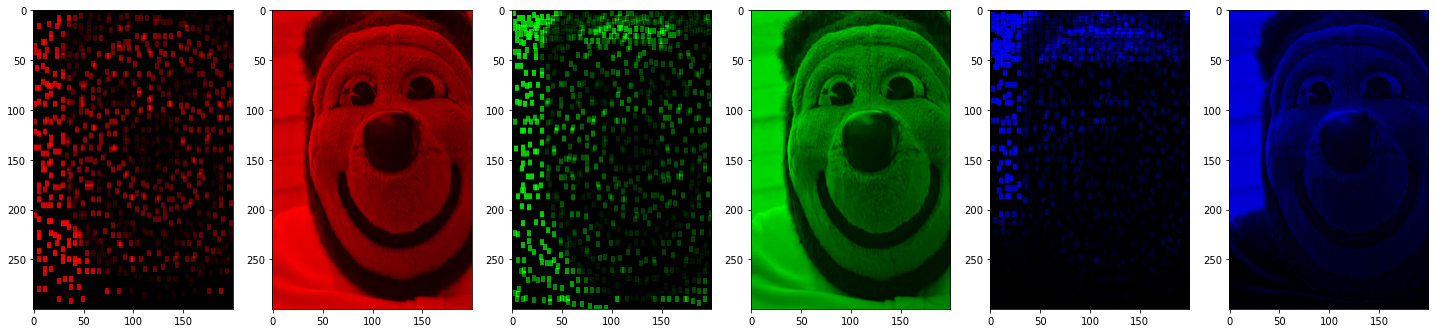

In [36]:
plot_channel(Psi_2, image)

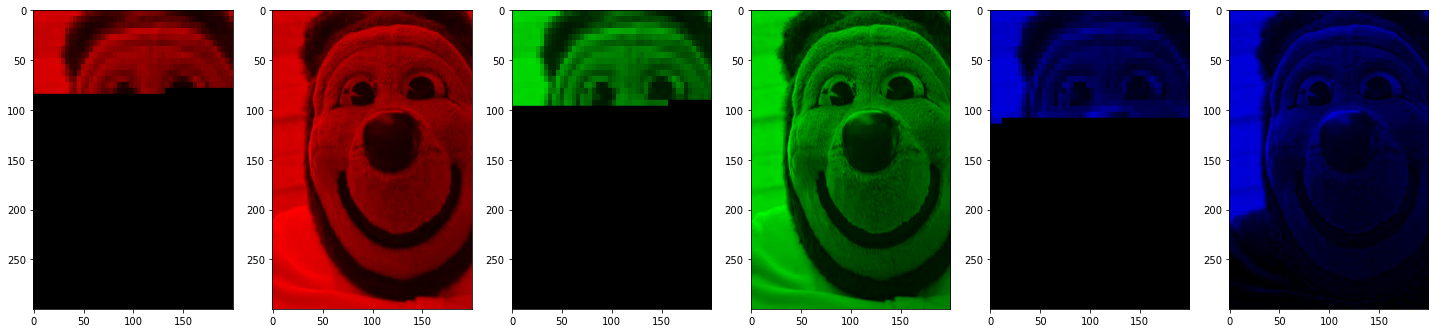

In [37]:
plot_channel(Psi_3, image)

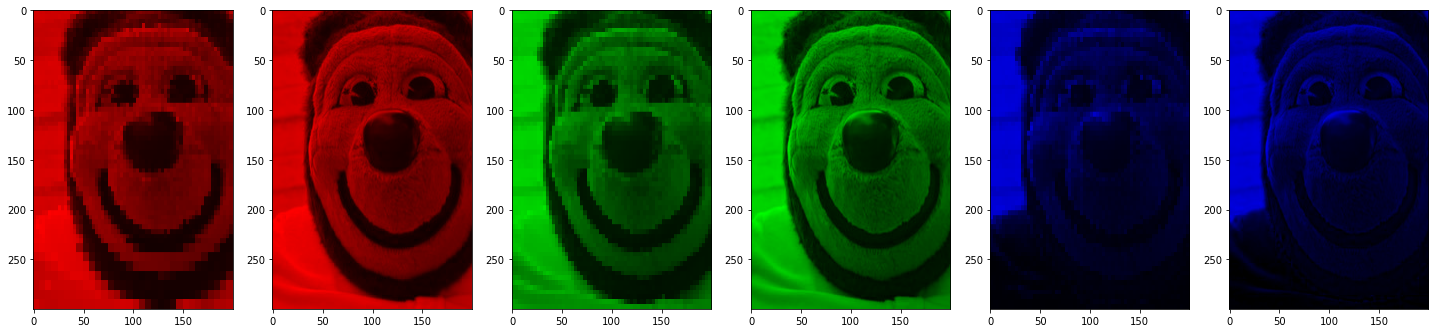

In [38]:
plot_channel(Psi_4, image)

`lpar1` = 100, `lpar2` = [5000/3, 5000/3, 5000/3], `lpar3` = [5000/3, 5000/3, 5000/3], `lpar4` = [5000/3, 5000/3, 5000/3]

Heuristic 2: The region in channel 0 is too small: 2 pixels.
Heuristic 2: The region in channel 1 is too small: 2 pixels.
Heuristic 2: The region in channel 2 is too small: 2 pixels.
Heuristic 4: The region in channel 0 is too small: 2 pixels.
Heuristic 4: The region in channel 1 is too small: 2 pixels.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Heuristic 4: The region in channel 2 is too small: 2 pixels.
Heuristic 2: Sum of mu is 3183.494187617209. Store 16383 vertices. Block shape is [6, 4]. Minimal region area is 4. Run time is 37.87372649999452
Heuristic 3: Sum of mu is 2869.2678430564943. Store 7500 vertices. Region shape is [6, 4]. Run time is 11.678612599993357
Heuristic 4: Sum of mu is 935.211783379782. Store 16383 vertices. Minimal region area is 4. Run time is 39.46823430000222


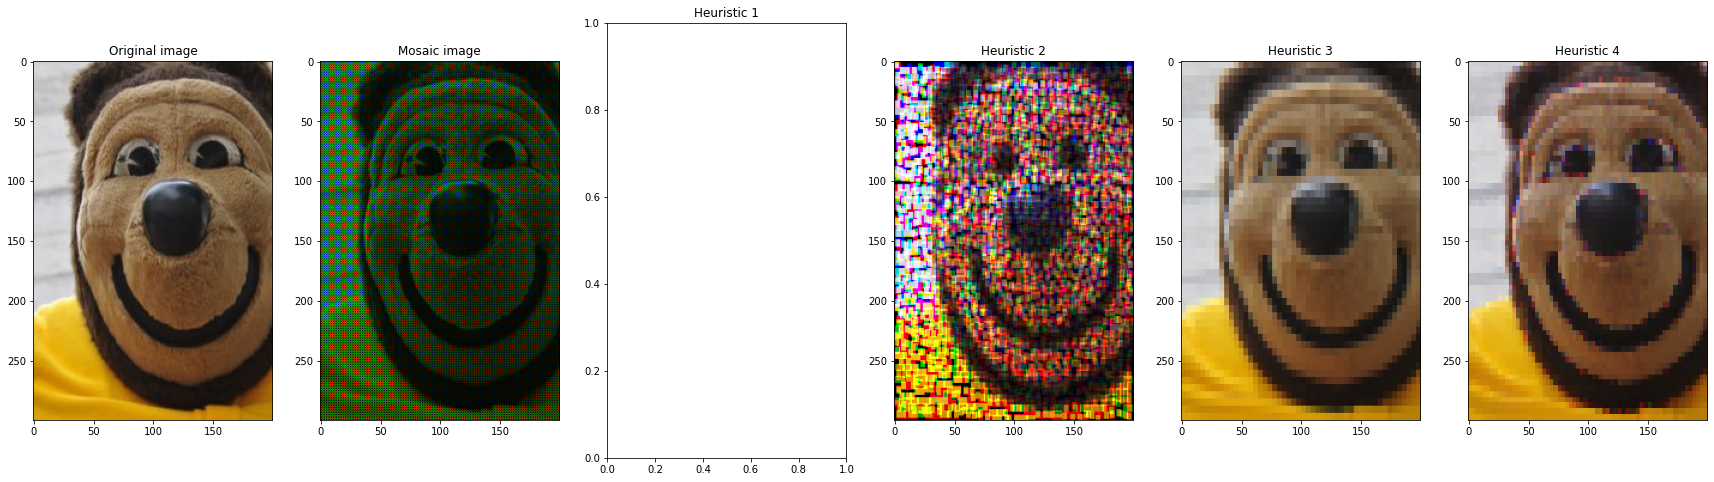

In [4]:
shape = (300, 200)
start = (50, 50)
image = imread('image/oski.png', 'png')   
image = image[start[0]:start[0]+shape[0], start[1]:start[1]+shape[1], :]

bayer_filter = np.stack(masks_CFA_Bayer(shape), axis=-1).astype(float)
mosaic_image = image * bayer_filter

lpar1 = 100
lpar2 = 5000
lpar3 = 5000
lpar4 = 5000

block_shape = [6, 4]
region_shape = [6, 4]
min_n_pix = 4

# start_1 = timer()
# _, Psi_1, mu_1, q_1 = heuristic_1(mosaic_image, [12, 8, 1], lpar=lpar1, tol=1e-2, verbose=False)
# end_1 = timer()

start_2 = timer()
Psi_2, mu_2, q_2 = heuristic_2(p_0=mosaic_image, block_shape=block_shape, min_n_pix=min_n_pix, lpars=[lpar2/3, lpar2/3, lpar2/3], verbose=False)
end_2 = timer()

start_3 = timer()
Psi_3, mu_3, q_3 = heuristic_3(p_0=mosaic_image, region_shape=region_shape, lpars=[lpar3/3, lpar3/3, lpar3/3], verbose=False)
end_3 = timer()

start_4 = timer()
Psi_4, mu_4, q_4 = heuristic_4(p_0=mosaic_image, min_n_pix=min_n_pix, lpars=[lpar4/3, lpar4/3, lpar4/3], verbose=False)
end_4 = timer()

# print(f'Heuristic 1: Sum of mu is {sum(mu_1)}. Store {len(q_1)} vertices. Run time is {end_1 - start_1}')
print(f'Heuristic 2: Sum of mu is {sum(mu_2)}. Store {len(q_2)} vertices. Block shape is {block_shape}. Minimal region area is {min_n_pix}. Run time is {end_2 - start_2}')
print(f'Heuristic 3: Sum of mu is {sum(mu_3)}. Store {len(q_3)} vertices. Region shape is {region_shape}. Run time is {end_3 - start_3}')
print(f'Heuristic 4: Sum of mu is {sum(mu_4)}. Store {len(q_4)} vertices. Minimal region area is {min_n_pix}. Run time is {end_4 - start_4}')

fig, axes = plt.subplots(1, 6, figsize=(30, 8))
axes[0].imshow(image)
axes[1].imshow(mosaic_image)
# axes[2].imshow(Psi_1)
axes[3].imshow(Psi_2)
axes[4].imshow(Psi_3)
axes[5].imshow(Psi_4)

axes[0].set_title('Original image')
axes[1].set_title('Mosaic image')
axes[2].set_title('Heuristic 1')
axes[3].set_title('Heuristic 2')
axes[4].set_title('Heuristic 3')
axes[5].set_title('Heuristic 4')
fig.savefig('comparison.png')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


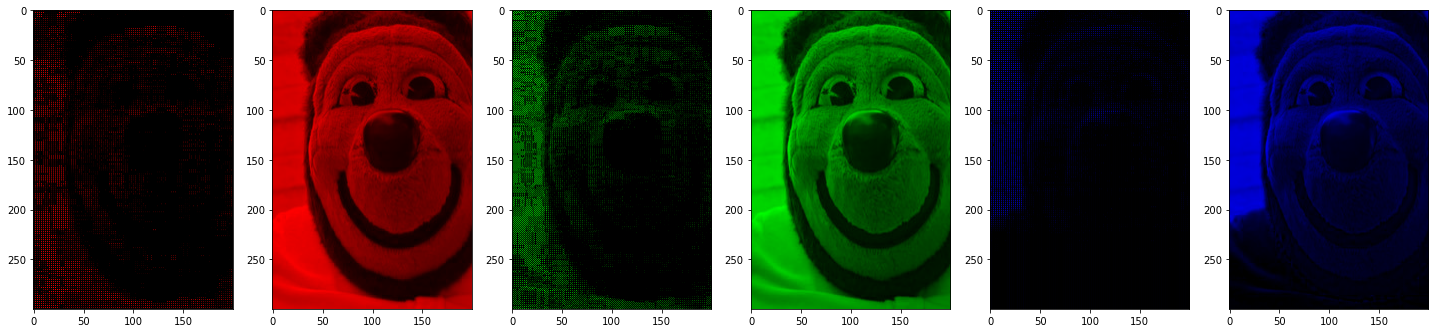

In [40]:
plot_channel(Psi_1, image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


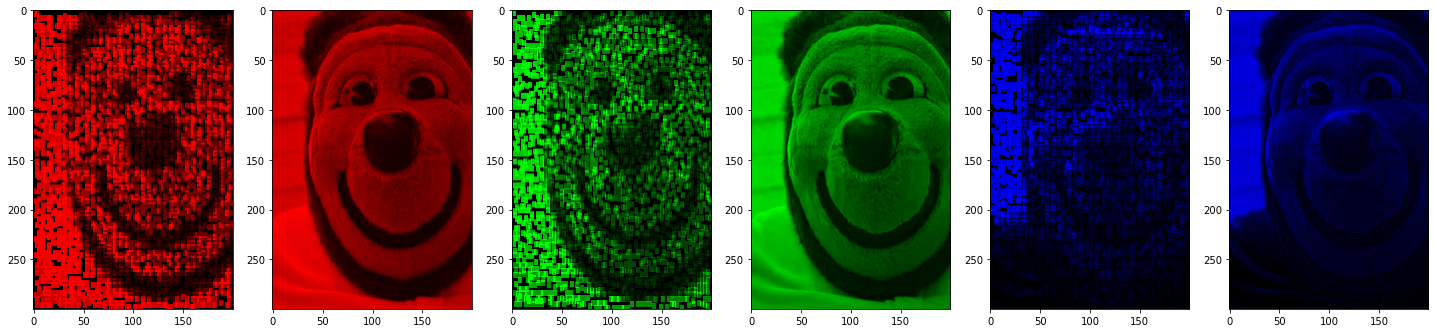

In [41]:
plot_channel(Psi_2, image)

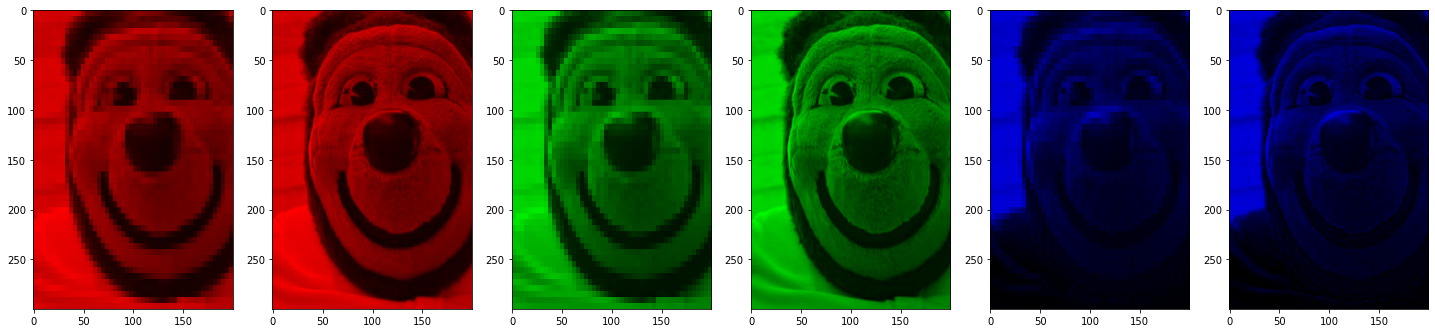

In [42]:
plot_channel(Psi_3, image)

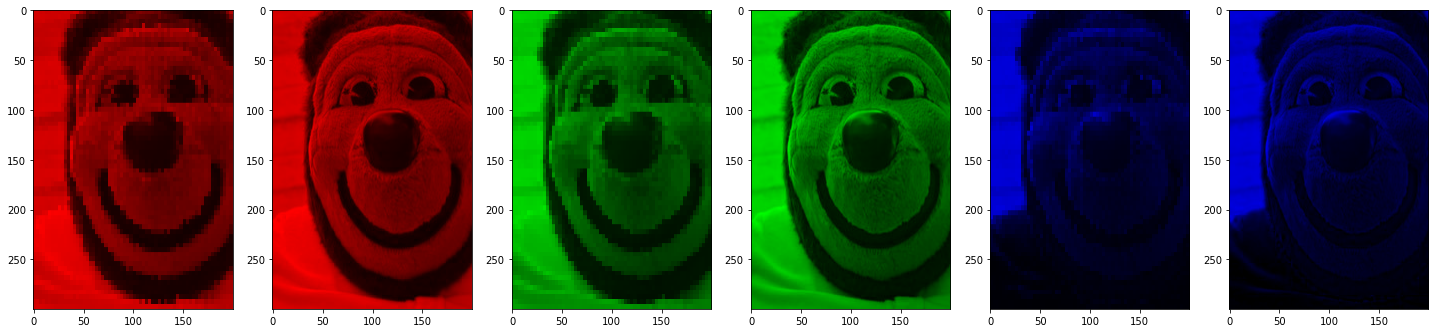

In [43]:
plot_channel(Psi_4, image)

`lpar1` = 100, `lpar2` = [5000/3, 5000/3, 5000/3], `lpar3` = [5000/3, 5000/3, 5000/3], `lpar4` = [5000/3, 5000/3, 5000/3], `block_shape` = [3, 2], `region_shape` = [3, 2]

Heuristic 2: The region in channel 0 is too small: 2 pixels.
Heuristic 2: The region in channel 1 is too small: 2 pixels.
Heuristic 2: The region in channel 2 is too small: 2 pixels.
Heuristic 4: The region in channel 0 is too small: 2 pixels.
Heuristic 4: The region in channel 1 is too small: 2 pixels.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Heuristic 4: The region in channel 2 is too small: 2 pixels.
Heuristic 2: Sum of mu is 5075.949133684859. Store 16383 vertices. Block shape is [3, 2]. Minimal region area is 4. Run time is 33.831533300020965
Heuristic 3: Sum of mu is 11485.93947681396. Store 30000 vertices. Region shape is [3, 2]. Run time is 36.612546100019244
Heuristic 4: Sum of mu is 935.211783379782. Store 16383 vertices. Minimal region area is 4. Run time is 36.55929279999691


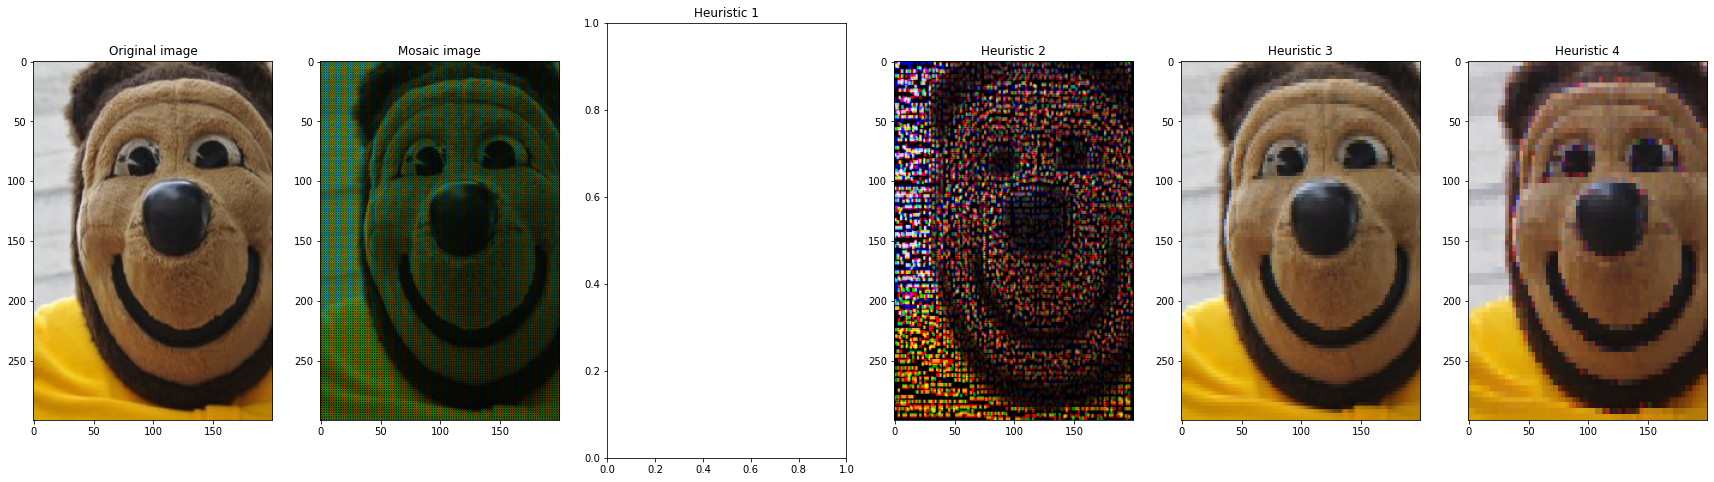

In [12]:
shape = (300, 200)
start = (50, 50)
image = imread('image/oski.png', 'png')   
image = image[start[0]:start[0]+shape[0], start[1]:start[1]+shape[1], :]

bayer_filter = np.stack(masks_CFA_Bayer(shape), axis=-1).astype(float)
mosaic_image = image * bayer_filter

lpar1 = 100
lpars2 = [3000, 2000, 2000]
lpars3 = [5000, 4000, 3000]
lpars4 = [10000/3, 10000/3, 10000/3]

block_shape = [3, 2]
region_shape = [3, 2]
min_n_pix = 4

# start_1 = timer()
# _, Psi_1, mu_1, the_1 = heuristic_1(mosaic_image, [12, 8, 1], lpar=lpar1, tol=1e-2, verbose=False)
# np.save("result/mu_1", mu_1)
# np.save("result/the_1", the_1)
# end_1 = timer()

start_2 = timer()
Psi_2, mu_2, the_2 = heuristic_2(p_0=mosaic_image, block_shape=block_shape, min_n_pix=min_n_pix, lpars=lpars2, verbose=False)
np.save("result/mu_2", mu_2)
np.save("result/the_2", the_2)
end_2 = timer()

start_3 = timer()
Psi_3, mu_3, the_3 = heuristic_3(p_0=mosaic_image, region_shape=region_shape, lpars=lpars3, verbose=False)
np.save("result/mu_3", mu_3)
np.save("result/the_3", the_3)
end_3 = timer()

start_4 = timer()
Psi_4, mu_4, the_4 = heuristic_4(p_0=mosaic_image, min_n_pix=min_n_pix, lpars=lpars4, verbose=False)
np.save("result/mu_4", mu_4)
np.save("result/the_4", the_4)
end_4 = timer()

# print(f'Heuristic 1: Sum of mu is {sum(mu_1)}. Store {len(the_1)} vertices. Run time is {end_1 - start_1}')
print(f'Heuristic 2: Sum of mu is {sum(mu_2)}. Store {len(the_2)} vertices. Block shape is {block_shape}. Minimal region area is {min_n_pix}. Run time is {end_2 - start_2}')
print(f'Heuristic 3: Sum of mu is {sum(mu_3)}. Store {len(the_3)} vertices. Region shape is {region_shape}. Run time is {end_3 - start_3}')
print(f'Heuristic 4: Sum of mu is {sum(mu_4)}. Store {len(the_4)} vertices. Minimal region area is {min_n_pix}. Run time is {end_4 - start_4}')

fig, axes = plt.subplots(1, 6, figsize=(30, 8))
axes[0].imshow(image)
axes[1].imshow(mosaic_image)
# axes[2].imshow(Psi_1)
axes[3].imshow(Psi_2)
axes[4].imshow(Psi_3)
axes[5].imshow(Psi_4)

axes[0].set_title('Original image')
axes[1].set_title('Mosaic image')
axes[2].set_title('Heuristic 1')
axes[3].set_title('Heuristic 2')
axes[4].set_title('Heuristic 3')
axes[5].set_title('Heuristic 4')
fig.savefig('comparison.png')

## Tensor Completion

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from colour_demosaicing import masks_CFA_Bayer
from timeit import default_timer as timer
from nonten import nonten_initial

from utils import plot_channel, the_to_q, q_to_the

shape = (300, 200)
start = (50, 50)
image = imread('image/oski.png', 'png')   
image = image[start[0]:start[0]+shape[0], start[1]:start[1]+shape[1], :]

bayer_filter = np.stack(masks_CFA_Bayer(shape), axis=-1).astype(float)
mosaic_image = image * bayer_filter

In [24]:
X = np.argwhere(bayer_filter.flatten() == 1).flatten()
Y = mosaic_image.flatten()[X]
r = mosaic_image.shape

In [27]:
mu = np.load('result/mu_3.npy')
the = np.load('result/the_3.npy')

In [28]:
# Pts = np.ones((un,1)) # (projected) active vertex set (Proj_U(S_t) in Line 2). Elements (psi) are the vertices of Proj_U(C_1)
# Vts = np.ones((np.sum(r),1)) # (non-projected) active vertex set (S_t in Line 2). Elements (theta which can be used to recover psi) are the vertices of C_1
# psi_q = np.ones(un) # the current iterate x_t (in Proj_U(C_1)) which is a cvx combination of elements in Pts using lamb as the coefficients
# the_q = np.ones(np.sum(r))
# lamb = np.array([[1]]) # convex comb coefficients to get the current iterate

In [33]:
Pts_init = list(map(lambda t: the_to_q(t, r).flatten()[X], the))
Pts_init = np.array(Pts_init).T

In [34]:
Vts_init = the.T

In [35]:
lamb_init = (mu / mu.sum())[None,:]

In [36]:
psi_q_init = np.sum(lamb_init * Pts_init, axis=1)

In [37]:
out = nonten_initial(X, Y, r, Pts_init, Vts_init, psi_q_init, lamb_init, lpar = 1, tol = 1e-6, verbose = True)

GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license